In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

# Task 1

In [2]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
x_train.shape

(60000, 28, 28)

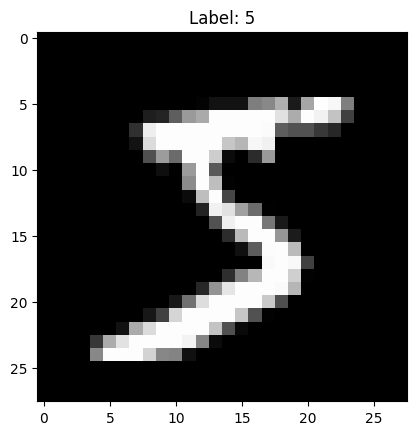

In [4]:
first_digit = x_train[0]
# plot the first sample
plt.imshow(first_digit, cmap='gray')
plt.title('Label: {}'.format(y_train[0]))
plt.show()

In [5]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [6]:
original_dim = x_train.shape[1]
original_dim

784

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [7]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):
    # loss_term = bernoulli loss between true x and predicted x_decoded
    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)
    # KL_term = KL divergence between normal with params z_mean, z_log_var and standard multivariate normal
    KL_term = 0.5 * tf.reduce_sum(-z_log_var - 1 + tf.math.exp(z_log_var) + z_mean**2, axis=1)
    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # epsilon = sample from standard normal distribution (sample batch observation from dim dimensional normal distribution)
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        # transform epsilon so it becomes from the normal distribution with params z_mean, z_log_var
        # use reparmetrization trick
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [9]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim,))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var]) 
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    200,960 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 10)        │      2,570 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 10)        │      2,570 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 10)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 271,892 (1.04 MB)

 Trainable params: 271,892 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,096 (1.03 MB)

 Trainable params: 270,096 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

## e)

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=16, batch_size=128)

Epoch 1/16
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 226.0745 - total_loss: 184.0499
Epoch 2/16
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 140.8229 - total_loss: 136.7582
Epoch 3/16
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 126.7832 - total_loss: 125.0792
Epoch 4/16
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 119.6246 - total_loss: 118.9385
Epoch 5/16
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 115.9277 - total_loss: 115.5523
Epoch 6/16
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 113.6227 - total_loss: 113.3652
Epoch 7/16
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 111.7080 - total_loss: 111.6877
Epoch 8/16
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 110.6015 - total_loss: 110.4203
Epoch 9/16
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 109.2842 - total_loss: 109.3430
Epoch 10/16
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 108.4263 - total_loss: 108.5259
Epoch 11/16
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 107.5948 - total_l

## f)

In [14]:
# representation in the latent space of observations from test ds
z_test_pred = vae.encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step


In [15]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = vae.decoder.predict(z_test_pred[2])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

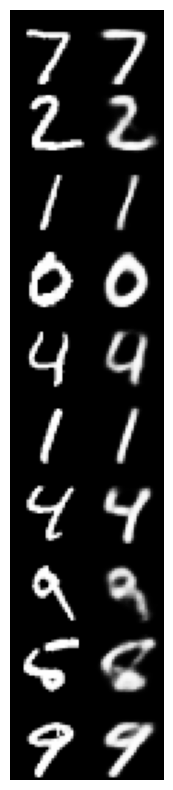

In [17]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [ ]:
# use z_test_pred

In [18]:
from sklearn.manifold import TSNE

In [19]:
tsne = TSNE(n_components=2)

In [23]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

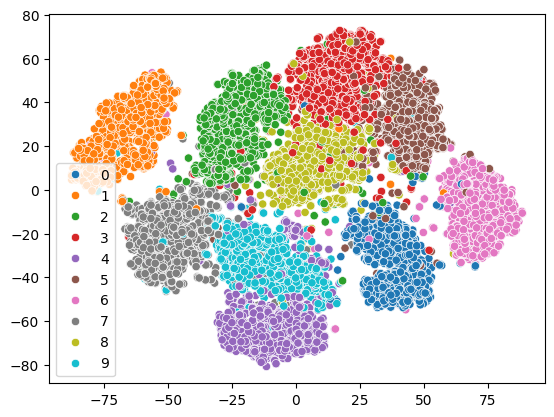

In [24]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

## h)

In [ ]:
# h) Generate new samples (new images of digits) from your trained VAE. To get new samples you have to
# sample from the prior distribution p(z) and then from the likelihood p(x|z)

In [25]:
k = 15
z_sample = tf.keras.backend.random_normal(shape=(k, latent_dim))
x_decoded = vae.decoder.predict(z_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


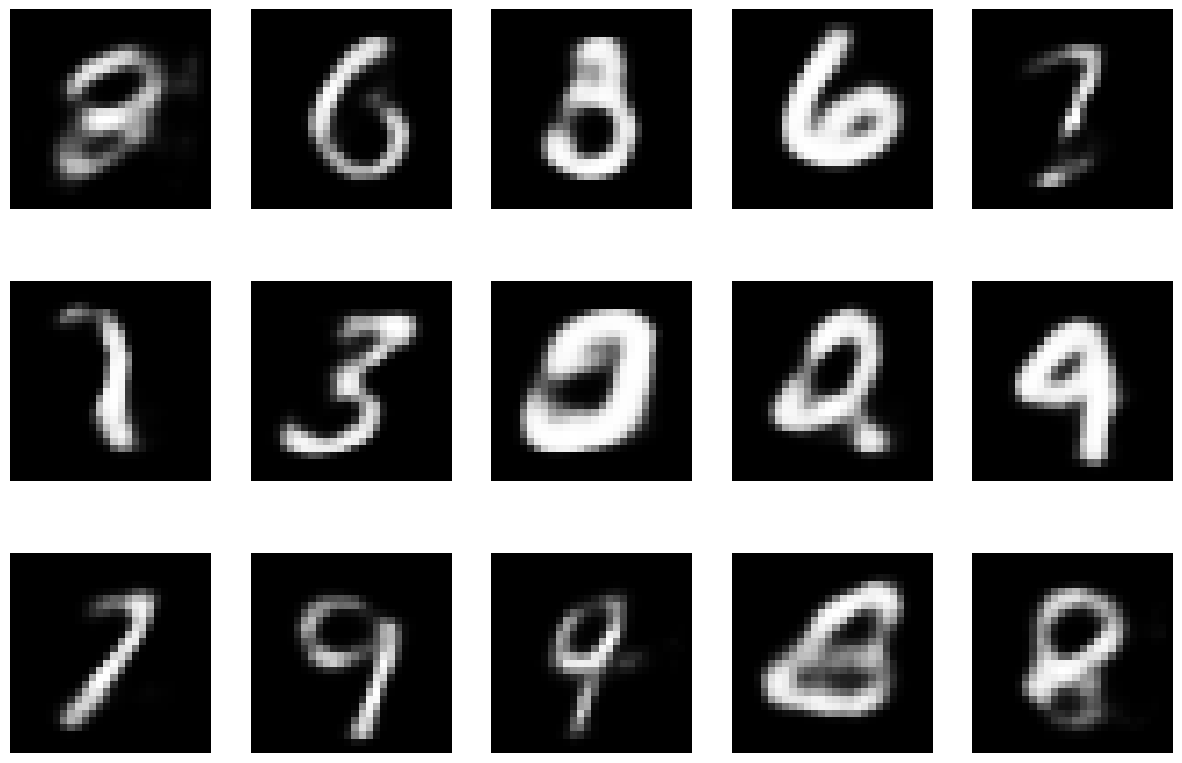

In [29]:
fig, axs = plt.subplots(3, 5, figsize=(15, 10))
axs = axs.ravel()
for i in range(k):
    axs[i].imshow(x_decoded[i].reshape(digit_size, digit_size), cmap='gray')
    axs[i].axis('off')

# Task 2

In [98]:
encoder_inputs = keras.Input(shape=(original_dim + 1,))
x = Dense(256, activation="relu")(encoder_inputs)
x = Dense(196, activation="relu")(x)
x = Dense(128, activation="tanh")(x)
x = Dense(64, activation="tanh")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
c_encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
c_encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 785)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 256)       │    201,216 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 196)       │     50,372 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 128)       │     25,216 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 64)        │      8,256 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 10)        │        650 │ dense_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 10)        │        650 │ dense_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_7          │ (None, 10)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 286,360 (1.09 MB)

 Trainable params: 286,360 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
latent_inputs = keras.Input(shape=(latent_dim + 1,))
x = Dense(256, activation="relu")(latent_inputs)
x = Dense(196, activation="relu")(x)
x = Dense(128, activation="tanh")(x)
x = Dense(64, activation="tanh")(x)
decoder_outputs = Dense(original_dim, activation="sigmoid")(x)
c_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
c_decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 196)            │        50,372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 128)            │        25,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 784)            │        50,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,876 (538.58 KB)

 Trainable params: 137,876 (538.58 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
class cVAE(keras.Model):
    def __init__(self, c_encoder, c_decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = c_encoder
        self.decoder = c_decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            label = data[:, -1]
            label = tf.reshape(label, [-1, 1])
            true_x = data[:, :-1]
            reconstruction = self.decoder(tf.concat([z, label], axis=1))
            total_loss = -elbo_vae(true_x, reconstruction, z_mean, z_log_var)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}

In [102]:
cvae = cVAE(c_encoder, c_decoder)
cvae.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001))

x_train_c = tf.concat([x_train, 
                       tf.cast(y_train.reshape(-1, 1), float)],
                       axis = 1)
                     
cvae.fit(x_train_c, epochs=48, batch_size=512)

Epoch 1/48
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 203.4733 - total_loss: 202.3468
Epoch 2/48
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 188.3258 - total_loss: 186.5555
Epoch 3/48
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 178.2096 - total_loss: 178.0191
Epoch 4/48
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 172.7411 - total_loss: 172.7768
Epoch 5/48
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 168.0496 - total_loss: 168.3241
Epoch 6/48
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 163.6820 - total_loss: 164.1194
Epoch 7/48
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 160.0470 - total_loss: 160.4447
Epoch 8/48
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 156.6404 - total_loss: 157.4607
Epoch 9/48
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 154.2496 - total_loss: 154.9247
Epoch 10/48
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 151.7319 - total_loss: 152.6337
Epoch 11/48
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 150.157

## f)

In [105]:
# representation in the latent space of observations from test ds
z_test_pred = cvae.encoder.predict(
    tf.concat([x_test, 
               tf.cast(y_test.reshape(-1, 1), float)],
               axis = 1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step


In [106]:
x_test_pred = cvae.decoder.predict(
    tf.concat([z_test_pred[2], 
               tf.cast(y_test.reshape(-1, 1), float)],
               axis = 1))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step


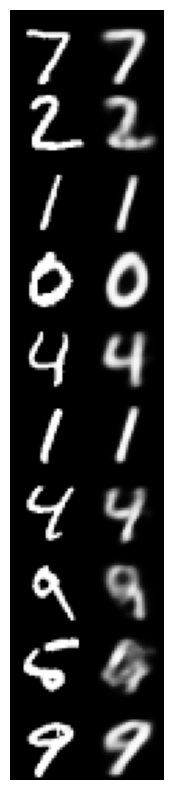

In [107]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = x_test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

## g)

In [112]:
tsne = TSNE(n_components=2)
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

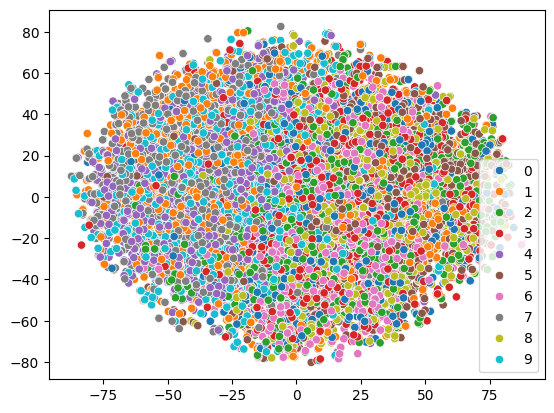

In [113]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], 
                y=z_test_pred_tsne[:N,1], 
                hue=y_test[:N], 
                palette=sns.color_palette("tab10"))
plt.show()

In [114]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z_test_pred_pca = pca.fit_transform(z_test_pred[2])

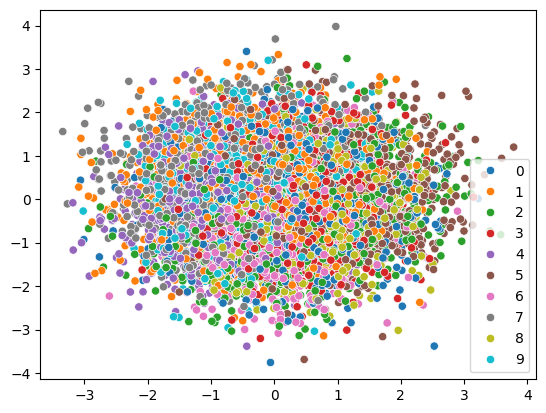

In [115]:
sns.scatterplot(x=z_test_pred_pca[:N,0],
                y=z_test_pred_pca[:N,1],
                hue=y_test[:N],
                palette=sns.color_palette("tab10"))
plt.show()

## h)

In [121]:
n_digits = 10
k = 10
z_sample = tf.keras.backend.random_normal(shape=(k, latent_dim))
labels =  tf.cast(np.repeat(np.arange(n_digits), k).reshape(-1, 1), float)

# repeat z_sample k times
z_sample_repeat = tf.tile(z_sample, [n_digits, 1])

x_decoded = cvae.decoder.predict(tf.concat([z_sample_repeat, labels], axis=1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


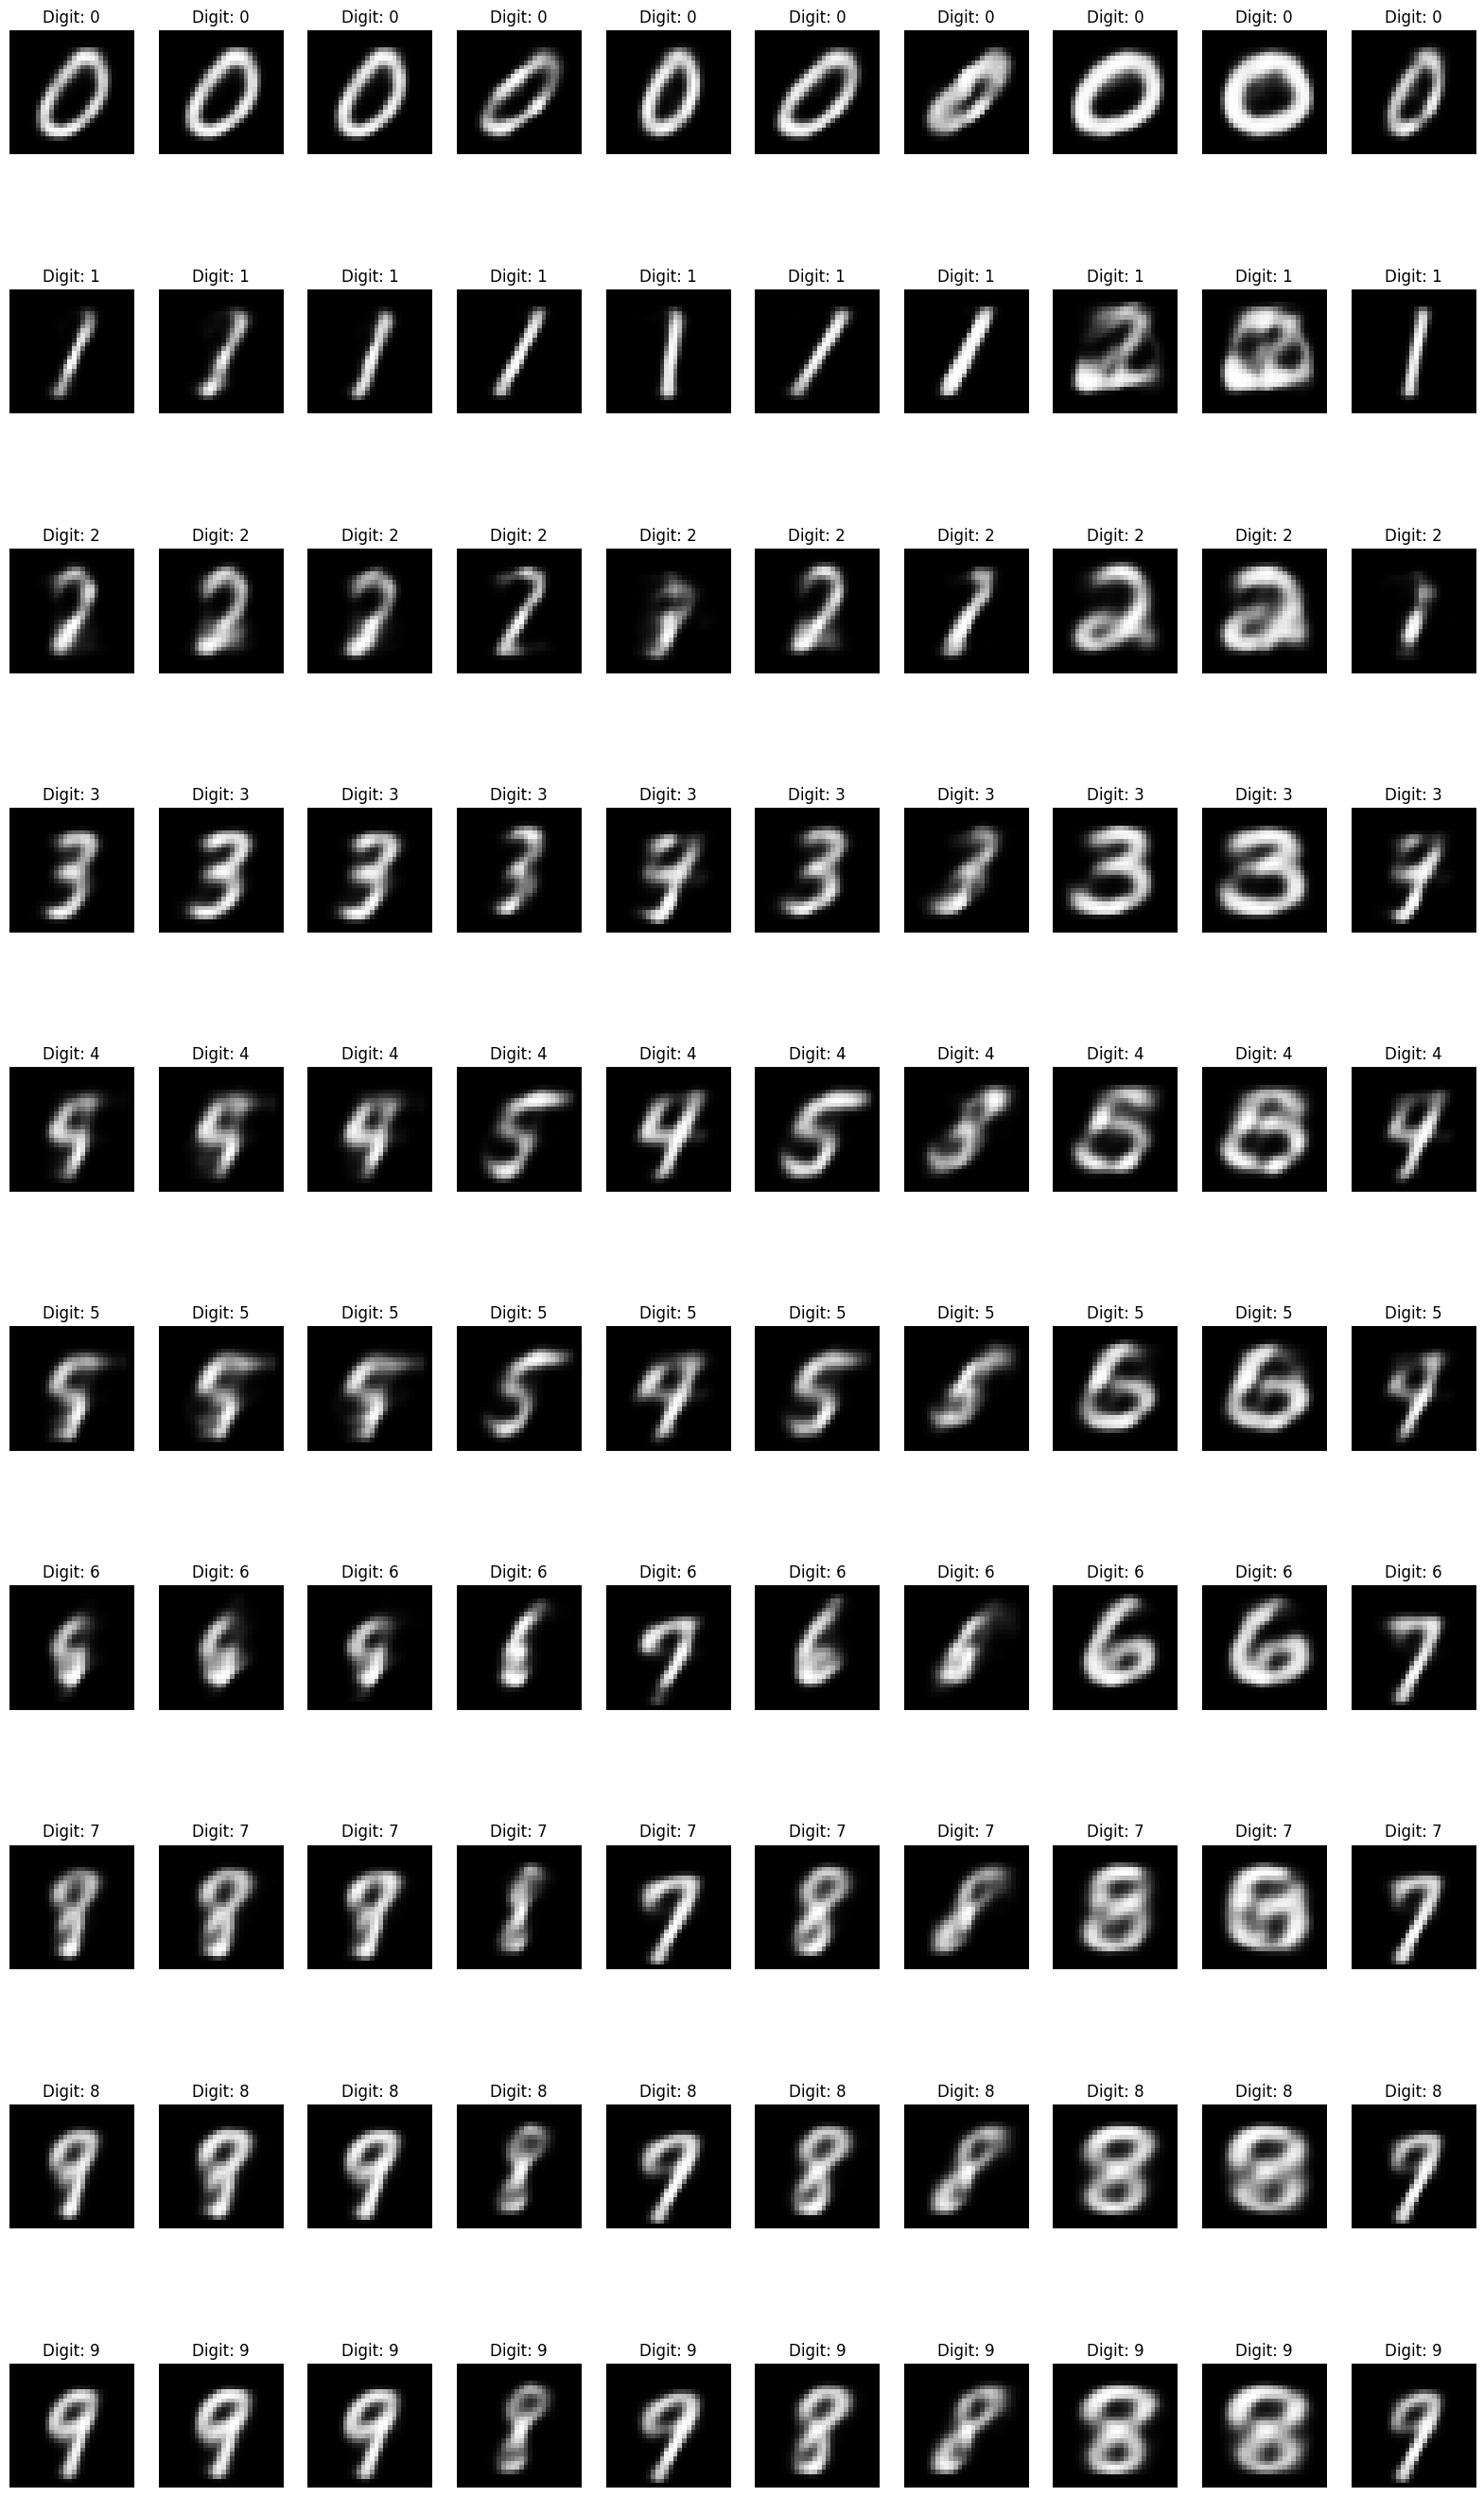

In [123]:
fig, axs = plt.subplots(n_digits, k, figsize=(20, 35))
axs = axs.ravel()
for i in range(k * n_digits):
    axs[i].imshow(x_decoded[i].reshape(digit_size, digit_size), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"Digit: {labels[i][0]:.0f}")